# Stacked test

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import copy

from gammapy.datasets import SpectrumDataset, Dataset, MapDataset, Datasets
from gammapy.irf import EDispKernel, EffectiveAreaTable2D
from gammapy.maps import MapAxis
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from numpy.testing import assert_allclose

In [2]:
region = CircleSkyRegion(
    center=SkyCoord(0, 0, unit="deg", frame="galactic"), radius=0.3 * u.deg
)

In [3]:
m_dataset1 = MapDataset.read("$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz")
dataset1 = m_dataset1.to_spectrum_dataset(region)
dataset1.mask_safe.data[0:2] = False

In [4]:
dataset2 = m_dataset1.to_spectrum_dataset(region)
dataset2.mask_safe.data[1:3] = False
dataset2.exposure = dataset2.exposure / 2.0
dataset2.counts = dataset2.counts / 2.0
dataset2.background = dataset2.background / 2.0

In [5]:
datasets = Datasets([dataset1, dataset2])
dataset_stacked = datasets.stack_reduce()

### The masks - OK

In [30]:
or_op = np.logical_or(dataset1.mask_safe.data.ravel(), dataset2.mask_safe.data.ravel())
np.all(or_op == dataset_stacked.mask_safe.data.ravel())

True

### Counts and Background - OK
The counts and background are simpy added together *outside the exclusion regions*

Text(0.5, 1.0, 'background')

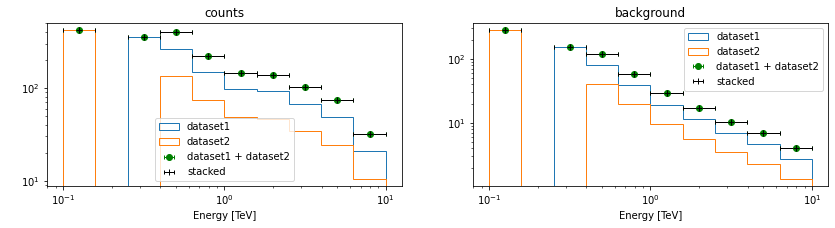

In [33]:
plt.figure(figsize=(14, 3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

c1 = (dataset1.counts * dataset1.mask_safe)
c2 = (dataset2.counts * dataset2.mask_safe)

c1.plot_hist(ax=ax1, label="dataset1")
c2.plot_hist(ax=ax1, label="dataset2")
(c1 + c2).plot(color="green", ax=ax1, fmt="o", label="dataset1 + dataset2")
dataset_stacked.counts.plot(ax=ax1, fmt="+", label="stacked", color="black")
ax1.legend()
ax1.set_title("counts")

b1 = (dataset1.background * dataset1.mask_safe)
b2 = (dataset2.background * dataset2.mask_safe)
b1.plot_hist(ax=ax2, label="dataset1")
b2.plot_hist(ax=ax2, label="dataset2")
(b1 + b2
).plot(color="green", ax=ax2, fmt="o", label="dataset1 + dataset2")
dataset_stacked.background.plot(
    ax=ax2, fmt="+", label="stacked", color="black"
)
ax2.legend()
ax2.set_title("background")

In [36]:
np.all((b1 + b2).data == (dataset_stacked.background.data))

True

In [37]:
np.all((c1 + c2).data == (dataset_stacked.counts.data))

True

### Npred computation after stacking - NOT OK



In [55]:
pwl = PowerLawSpectralModel(index=4)
model = SkyModel(spectral_model=pwl, name="test")

datasets.models = model
dataset_stacked.models = model

Text(0.5, 1.0, 'npred')

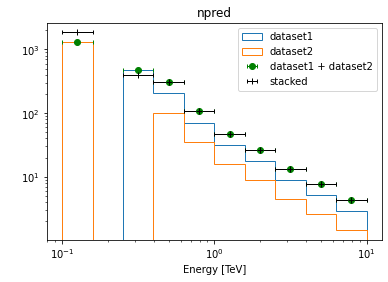

In [56]:
n1 = dataset1.npred() * dataset1.mask_safe
n2 = dataset2.npred() * dataset2.mask_safe
(n1).plot_hist(label="dataset1")
(n2).plot_hist(label="dataset2")
(n1+n2).plot(color="green", fmt="o", label="dataset1 + dataset2")
dataset_stacked.npred().plot(fmt="+", label="stacked", color="black")
plt.legend()
plt.title("npred")

In [57]:
np.all((n1 + n2).data == (dataset_stacked.npred().data))

False

In [58]:
# The difference
(n1 + n2).data - dataset_stacked.npred().data

array([[[-5.23730879e+02]],

       [[ 0.00000000e+00]],

       [[ 7.93559948e+01]],

       [[ 1.12082635e-05]],

       [[-9.01299217e-07]],

       [[ 8.19581970e-07]],

       [[-1.28193007e-06]],

       [[ 2.54466576e-07]],

       [[ 3.65477435e-08]],

       [[-7.40201944e-09]]])

In [59]:
# relative diff
((n1 + n2).data - dataset_stacked.npred().data)/dataset_stacked.npred().data

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([[[-2.82972547e-01]],

       [[            nan]],

       [[ 2.01622616e-01]],

       [[ 3.65301834e-08]],

       [[-8.43886544e-09]],

       [[ 1.74367199e-08]],

       [[-4.84999647e-08]],

       [[ 1.90674487e-08]],

       [[ 4.74323018e-09]],

       [[-1.69748288e-09]]])